![Py4Eng](../logo.png)

# Finetuning pretrained model with metric learning
## Yoav Ram

This notebook shows a step-by-step finetuning workflow using a pretrained [EfficientNetV2](https://arxiv.org/pdf/2104.00298) backbone (from `timm`) and PyTorch. The target dataset is the [Hyena ID 2022](https://lila.science/datasets/hyena-id-2022/) dataset (3104 photos, 256 individuals).
The task is viewpoint prediction - classifying the viewpoint on the hyena in the images.

In [1]:
%matplotlib inline
import os
import shutil
from collections import Counter
import tarfile
import urllib.request
import random
from tqdm import tqdm
from pathlib import Path
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
import timm
from sklearn.model_selection import StratifiedShuffleSplit
from pytorch_metric_learning.losses import ArcFaceLoss

print('torch', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
num_workers = 8 if torch.cuda.is_available() else 0
print('Device:', device)

torch 2.7.1
Device: mps


# Data

We Download the [Hyena ID 2022 dataset](https://lila.science/datasets/hyena-id-2022/) and extract to `data/hyena`. 

In [2]:
url = "http://us-west-2.opendata.source.coop.s3.amazonaws.com/agentmorris/lila-wildlife/wild-me/hyena.coco.tar.gz"
out_path = '../data/hyena.coco.tar.gz'
extract_dir = '../data/hyena'
chunk = 1024 * 1024

os.makedirs(os.path.dirname(out_path), exist_ok=True)

In [3]:
if not os.path.exists(extract_dir):
    if not os.path.exists(out_path):
        print(f'Downloading {url} to {out_path}')
        with urllib.request.urlopen(url) as r, open(out_path, 'wb') as f:
            total = r.getheader('Content-Length')
            total = int(total) if total else None
            with tqdm(total=total, unit='B', unit_scale=True, desc='download') as p:
                while True:
                    data = r.read(chunk)
                    if not data:
                        break
                    f.write(data)
                    p.update(len(data))
    else:
        print(f'File {out_path} already exists, skipping download.')

    print(f"Extracting {out_path}")
    with tarfile.open(out_path, 'r:gz') as t:
        os.makedirs(extract_dir, exist_ok=True)
        t.extractall(path=extract_dir)
else:
    print(f'Extraction directory already exists, skipping extraction.')

Extraction directory already exists, skipping extraction.



The metadata is in `../data/hyena/hyena.coco/annotations/instances_train2022.json`, which contains the bounding box of the individuals in the images, as well as their the viewpoints.

Load COCO-style annotations and build mapping from filename to bbox and to viewpoint.

In [71]:
with open('../data/hyena/hyena.coco/annotations/instances_train2022.json', 'r') as f:
    metadata = json.load(f)
bboxes = {a['image_id']: a['bbox'] for a in metadata['annotations']}
viewpoints = {a['image_id']: a['viewpoint'] for a in metadata['annotations']}

All the hyena images are now in `../data/hyena/hyena.coco/images/train2022` folder (`test2022` and `val2022` are empty). Image filenames are just the image running number.

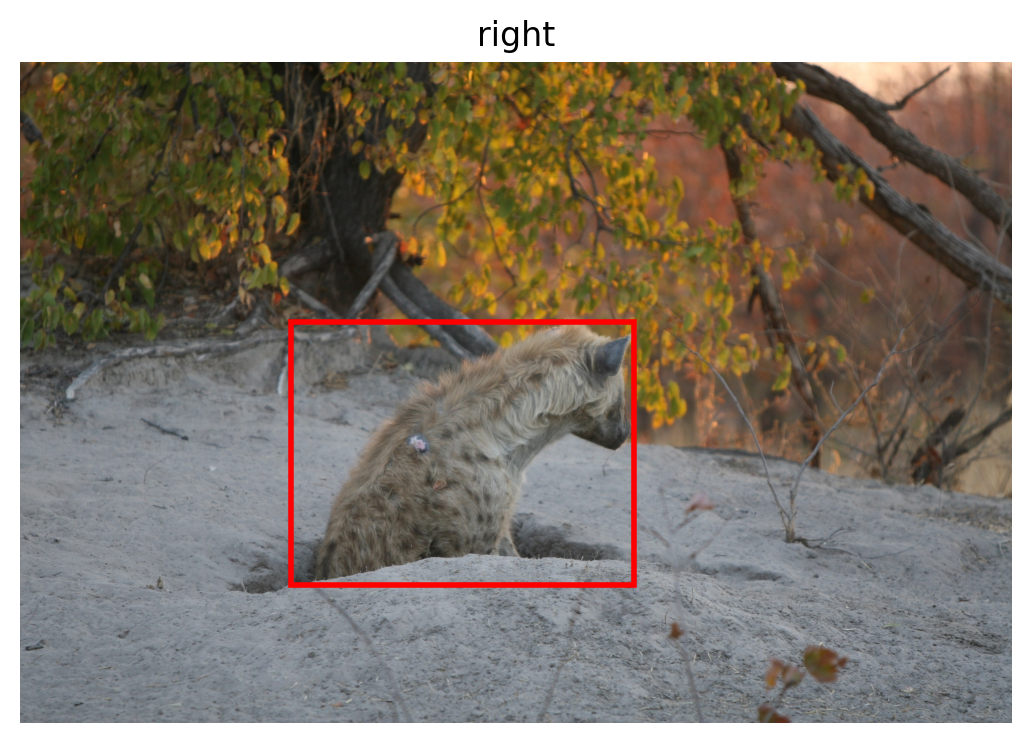

In [73]:
path_template = '../data/hyena/hyena.coco/images/train2022/{:012d}.jpg'

def plot_image(image_id, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    path = path_template.format(image_id)
    image = Image.open(path)    
    ax.imshow(image)
    bbox = bboxes[image_id]
    viewpoint = viewpoints[image_id]
    x, y, w, h = bbox  # Top-Left X, Top-Left Y, Width, Height
    rect = plt.Rectangle((x, y), w, h, fill=False, color='red', lw=2)
    ax.add_patch(rect)
    ax.axis('off')
    ax.set_title(viewpoint)
    return ax

plot_image(np.random.randint(1, len(bboxes)+1));

Now we get the labels -- the viewpoints.

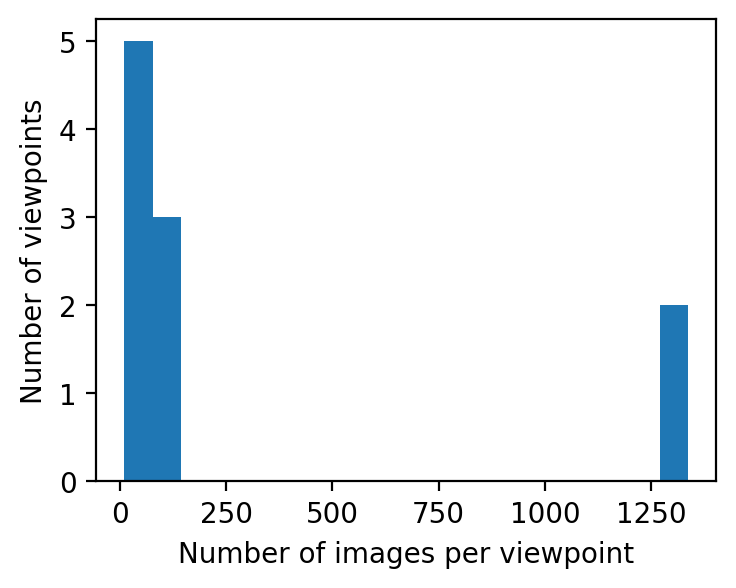

In [74]:
img_ids = np.array(list(viewpoints.keys()))

counter = Counter(viewpoints.values())
plt.figure(figsize=(4, 3))
plt.hist(counter.values(), 20)
plt.xlabel('Number of images per viewpoint');
plt.ylabel('Number of viewpoints');

This histogram is very skewed because most viewpoints are either right or left.

Map viewpoints to integers and back.

In [75]:
view2id = {k:i for i,k in enumerate(counter.keys())}
int2view = {i:k for k,i in view2id.items()}
labels = np.array([view2id[viewpoints[img]] for img in img_ids])
n_classes = int(labels.max() + 1)
print("Number of classes:", n_classes)

Number of classes: 10


Split to train and test sets by defining the indexes that go to either set.
We use a stratified split so each viewpoint is represented in train and val

In [78]:
rng = np.random.default_rng(23)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=23)
train_idx, val_idx = next(sss.split(img_ids, labels))
print("Number of train samples {}\nNumber of validation samples {}".format(len(train_idx), len(val_idx)))

Number of train samples 2793
Number of validation samples 311


We now define a dataset class that takes image identifiers and their corresponding labels and on each iteration loads and returns an image and its label. Images are cropped to the bounding boxes (red box on image above) and transformed with whatever transformers are given to the `HyenaDataset` object.

In [79]:
class HyenaDataset(Dataset):    
    def __init__(self, img_ids, labels, transform=None):
        assert len(img_ids) == len(labels)
        self.img_ids = img_ids
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        image_id = self.img_ids[idx]
        label = self.labels[idx]
        path = path_template.format(image_id)
        image = Image.open(path).convert('RGB')
        # crop to bbox
        bbox = bboxes[image_id]
        x, y, w, h = bbox
        image = image.crop((x, y, x + w, y + h))
        # apply transforms
        if self.transform:
            image = self.transform(image)
        return image, label

Definte the image transforms.
For the validation set, we just resize the image to the size suitable for the model, convert to PyTorch tensor, and normalize colors.

For the training transforms, we also augment the data using cropping, rotations, color jitters, and even random erasing. 
Note that we do not perform horizontal flips as those will mess up the viewpoint!

For more details on augmentations, see [Mumuni & Mumuni, 2022](https://www.sciencedirect.com/science/article/pii/S2590005622000911)

In [88]:
img_size = 224

val_transforms = T.Compose([
    T.Resize((img_size, img_size)),    
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def unnormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

train_transforms = T.Compose([
    T.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.RandomErasing(p=0.25, scale=(0.02, 0.25), ratio=(0.3, 3.3))
])

Now we create the datasets and data loaders.

In [ ]:
batch_size = 64

train_ds = HyenaDataset(img_ids=img_ids[train_idx], labels=labels[train_idx], transform=train_transforms)
val_ds = HyenaDataset(img_ids=img_ids[val_idx], labels=labels[val_idx], transform=val_transforms)

# Create a WeightedRandomSampler so batches are class-balanced (helps with skewed viewpoint distribution)
from torch.utils.data import WeightedRandomSampler
counts = np.bincount(labels[train_idx], minlength=n_classes)
class_weights = 1.0 / (counts + 1e-6)
sample_weights = class_weights[labels[train_idx]]
sampler = WeightedRandomSampler(weights=torch.DoubleTensor(sample_weights), num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler, num_workers=num_workers)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Here's how the images look like coming out of the dataset object.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7107843].


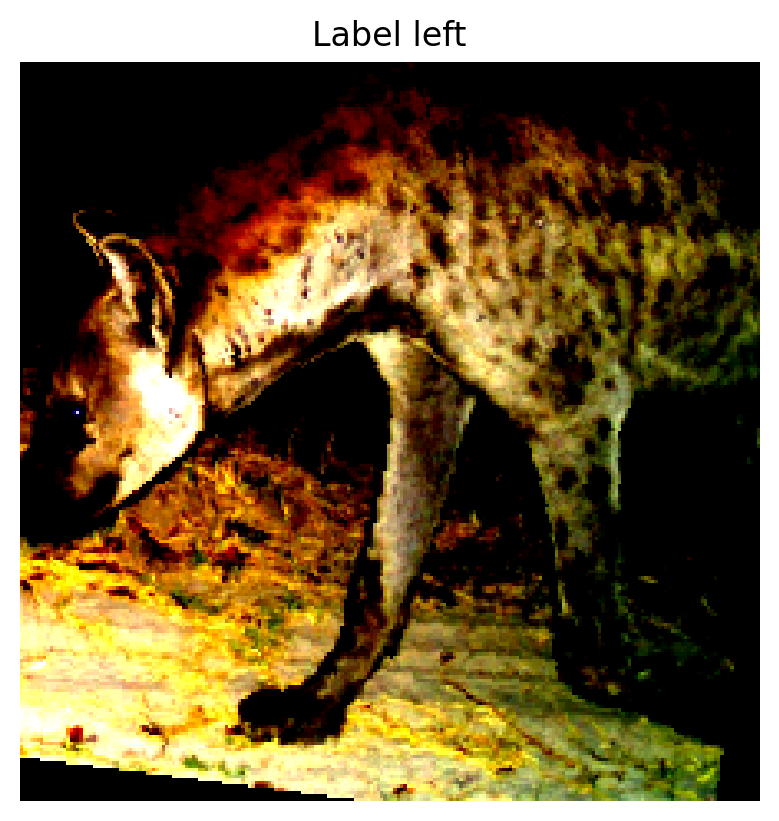

In [101]:
img, lbl = train_ds[np.random.randint(len(train_ds))]
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.title(f'Label {int2view[lbl]}');

## Model
Load a pretrained **EfficientNetV2_s** without the classifier head. We use the small variant `_s` for speed; change to `_m` or `_l` if you want better performance.
See [model card](https://huggingface.co/timm/tf_efficientnetv2_s.in21k_ft_in1k) for details.

We set `num_classes` so the model is loaded with a new classifier head with just 10 classes.

In [103]:
model_name = 'tf_efficientnetv2_s.in21k_ft_in1k'
model = timm.create_model(
    model_name, 
    pretrained=True, 
    num_classes=n_classes
)
print(model)

EfficientNet(
  (conv_stem): Conv2dSame(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path): Identity()
      )
      (1): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path):

Let's see the model in action. Because we specificed `num_classes=10`, the outputs are the logits of the classification head. To get proper probabilities ($\hat{y}$) we would need to use `softmax`, but we don't really need the probabilities.

In [104]:
logits = model(img.unsqueeze(0))
print("Logits shape:", logits.shape)
print(logits)

Logits shape: torch.Size([1, 10])
tensor([[-0.5105,  1.6331,  4.5255, -2.8620, -0.3113, -1.8977,  0.6390, -5.1065,
         -6.5713,  5.7682]], grad_fn=<AddmmBackward0>)


### Freeze backbone and train classifier head
We freeze all parameters except the classifier parameters.

In [107]:
# Freeze backbone
for p in model.parameters():
    p.requires_grad = False
# Unfreeze classifier head
for p in model.get_classifier().parameters():
    p.requires_grad = True

Define an optimizer for the model parameters. Use *AdamW* with small weight decay to reduce overfitting.

Define a scheduler for the model optimizer so the learning rate is reduced when the loss plateaus.

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
# Use class-weighted CrossEntropyLoss to combat class imbalance and add mild label smoothing to reduce overconfidence
counts = np.bincount(labels[train_idx], minlength=n_classes)
class_weights = 1.0 / (counts + 1e-6)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.1)

Define a function to train the model for one epoch and another function to evaluate it at the end of the epoch.

In [112]:
def train(model, loss_fn, data_loader, optimizer):
    model.train()
    running_loss = 0.0 # for the entire epoch
    pbar = tqdm(data_loader, desc='Training', unit='batch')
    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
        pbar.set_postfix({'loss': f'{loss:.4f}'})
    return running_loss / len(data_loader.dataset)

In [115]:
def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return correct / total if total else 0.0

Now let's train just the classifier head (the backbone is frozen) for several epochs.
We first move the model and loss function to the accelerator device.

In [ ]:
model.to(device)
loss_fn = loss_fn.to(device)

val_acc = []
train_acc = []
n_epochs = 20  # train head longer but with early stopping
epoch = 0
train_acc.append(evaluate(model, train_loader))
val_acc.append(evaluate(model, val_loader))
print(f'Before training: train acc {train_acc[-1]:.4f} | val acc {val_acc[-1]:.4f}')
while epoch < n_epochs:
    loss = train(model, loss_fn, train_loader, optimizer)
    train_acc.append(evaluate(model, train_loader))
    val_acc.append(evaluate(model, val_loader))
    scheduler.step(val_acc[-1])
    print(f'Epoch {epoch+1}/{n_epochs}: loss {loss:.4f} | train acc {train_acc[-1]:.4f} | val acc {val_acc[-1]:.4f}')
    epoch += 1

Before training: train acc 0.1267 | val acc 0.0997


Training: 100%|██████████| 44/44 [00:55<00:00,  1.26s/batch, loss=4.0121]


Epoch 1/5: loss 6.0627 | train acc 0.2485 | val acc 0.1897


Training: 100%|██████████| 44/44 [00:53<00:00,  1.22s/batch, loss=4.3491]


Epoch 2/5: loss 4.9937 | train acc 0.2939 | val acc 0.2572


Training: 100%|██████████| 44/44 [00:54<00:00,  1.24s/batch, loss=2.8748]


Epoch 3/5: loss 4.4316 | train acc 0.3287 | val acc 0.2894


Training: 100%|██████████| 44/44 [00:54<00:00,  1.23s/batch, loss=4.2039]


Epoch 4/5: loss 4.1930 | train acc 0.3527 | val acc 0.3087


Training: 100%|██████████| 44/44 [00:53<00:00,  1.21s/batch, loss=2.5969]


Epoch 5/5: loss 4.1962 | train acc 0.3634 | val acc 0.3280


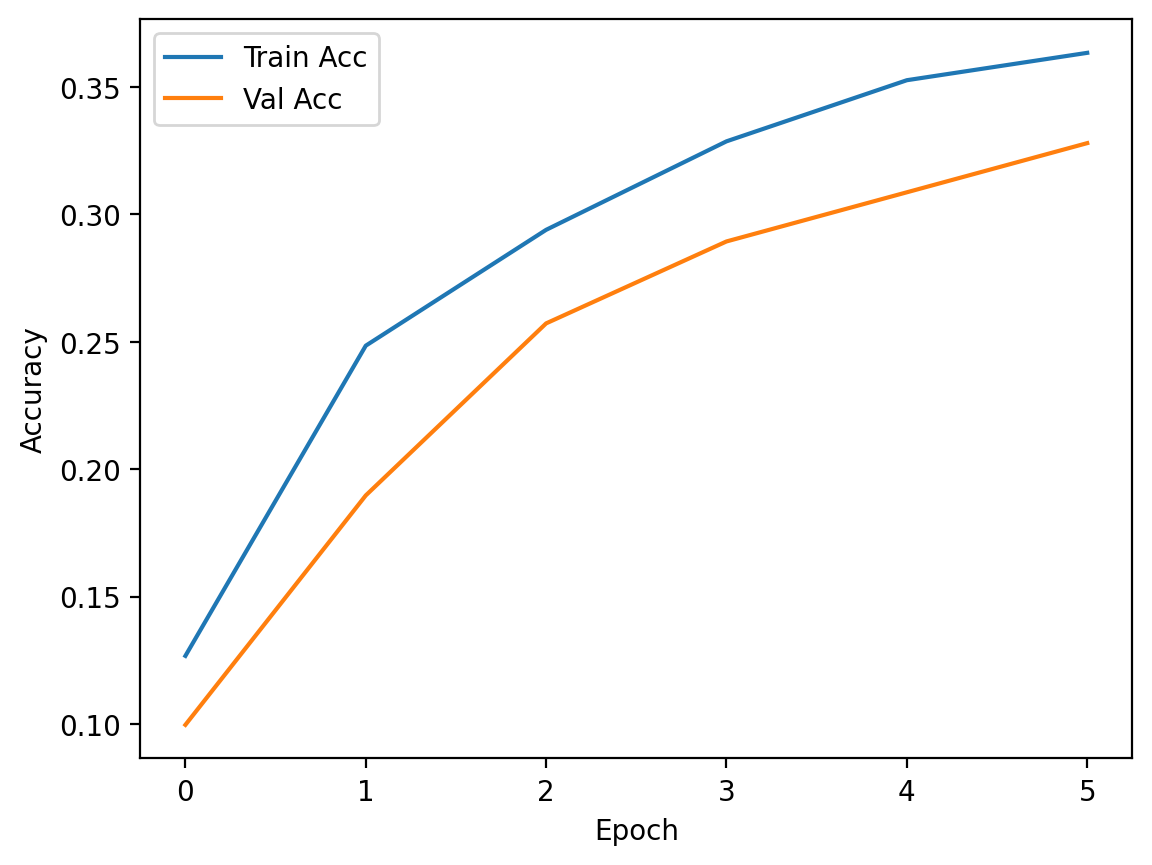

In [122]:
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

### Unfreeze and finetune the whole model
Now we unfreeze all parameters and create a new optimizer for all the parameters with a lower learning rate.

In [ ]:
for p in model.parameters():
    p.requires_grad = True

# Use discriminative learning rates: lower for backbone, higher for classifier head
classifier_params = list(model.get_classifier().parameters())
backbone_params = [p for p in model.parameters() if p not in classifier_params]
optimizer = torch.optim.AdamW([
    {'params': backbone_params, 'lr': 1e-5},
    {'params': classifier_params, 'lr': 1e-4}
], weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10)


Now continue training the entire model (backbone+head).
This typically improves performance but takes longer as we have many more parameters.

In [ ]:
n_epochs = 50
print(f'Before training: val_acc {val_acc[-1]:.4f}')

# Early stopping for full finetune
best_val_full = val_acc[-1]
best_model_wts_full = model.state_dict()
patience_full = 10
no_improve_full = 0

while epoch < n_epochs:
    loss = train(model, loss_fn, train_loader, optimizer)
    train_acc.append(evaluate(model, train_loader))
    val_acc.append(evaluate(model, val_loader))
    print(f'Epoch {epoch+1}/{n_epochs}: loss {loss:.4f} | train_acc {train_acc[-1]:.4f} | val_acc {val_acc[-1]:.4f}')
    # LR scheduler step (ReduceLROnPlateau expects metric)
    scheduler.step(val_acc[-1])
    if val_acc[-1] > best_val_full + 1e-5:
        best_val_full = val_acc[-1]
        best_model_wts_full = model.state_dict()
        no_improve_full = 0
    else:
        no_improve_full += 1
    if no_improve_full >= patience_full:
        print(f'No improvement for {patience_full} epochs. Early stopping full finetune.')
        break
    epoch += 1

# restore best full-finetune weights
model.load_state_dict(best_model_wts_full)

Before training: val_acc 0.3280


Training: 100%|██████████| 44/44 [01:17<00:00,  1.76s/batch, loss=4.6524]


Epoch 6/10: loss 3.8120 | train_acc 0.4189 | val_acc 0.3987


Training: 100%|██████████| 44/44 [01:15<00:00,  1.71s/batch, loss=1.8646]


Epoch 7/10: loss 3.1007 | train_acc 0.4619 | val_acc 0.4502


Training: 100%|██████████| 44/44 [01:15<00:00,  1.71s/batch, loss=2.1219]


Epoch 8/10: loss 2.7654 | train_acc 0.4991 | val_acc 0.4695


Training: 100%|██████████| 44/44 [01:15<00:00,  1.72s/batch, loss=1.3087]


Epoch 9/10: loss 2.2794 | train_acc 0.5453 | val_acc 0.5113


Training: 100%|██████████| 44/44 [01:16<00:00,  1.75s/batch, loss=2.9298]


Epoch 10/10: loss 1.9655 | train_acc 0.5682 | val_acc 0.5627


In [ ]:
ckpt_path = f'../data/{model_name}_viewpoint_finetune.pth'

torch.save({    
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'model_name': model_name,
    'train_acc': train_acc,
    'val_acc': val_acc,
}, ckpt_path)
print(f'Checkpoint saved to {ckpt_path}')

Checkpoint saved to ../data/tf_efficientnetv2_s.in21k_ft_in1k_viewpoint_finetune.pth


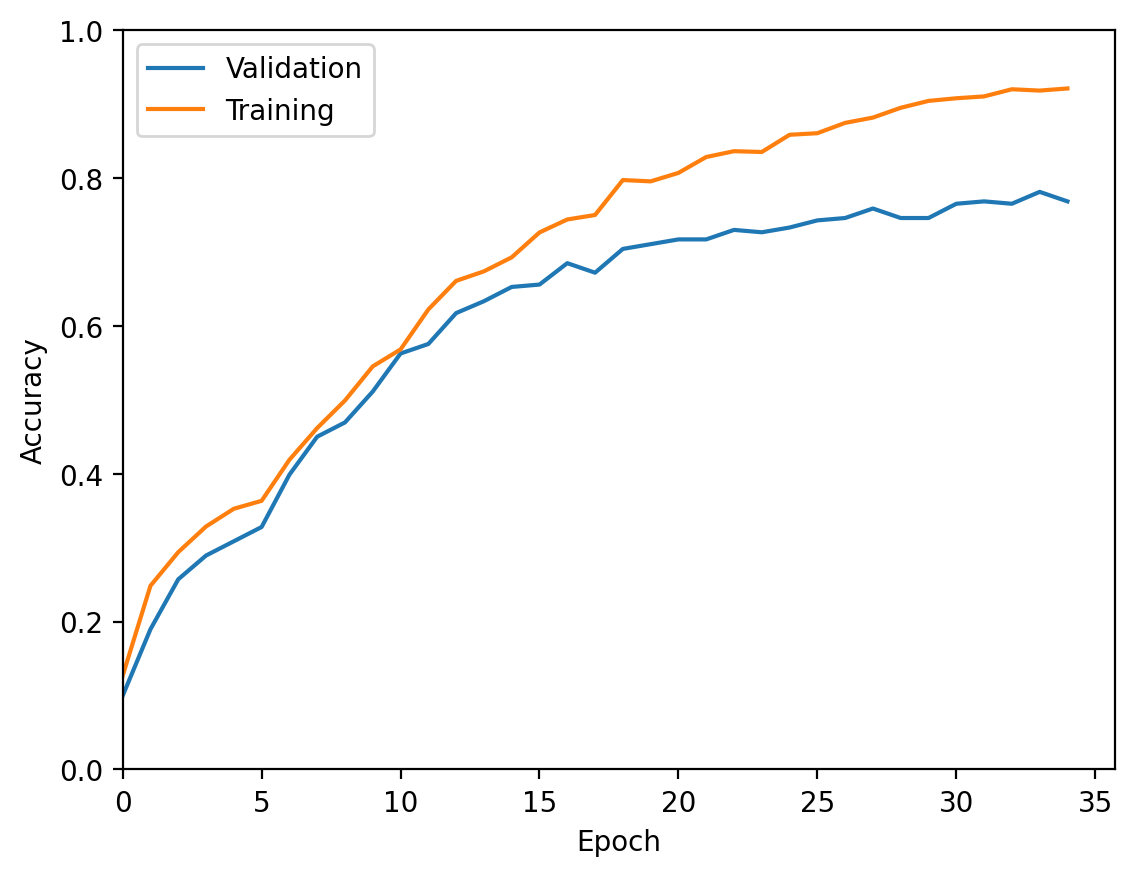

In [129]:
plt.plot(val_acc, label='Validation')
plt.plot(train_acc, label='Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xlim(0, None)
plt.legend();

## Use the model

We load the model from the checkpoint and use it on the validation set to comparet hyena images.

In [133]:
model_name = 'tf_efficientnetv2_s.in21k_ft_in1k'
model = timm.create_model(
    model_name, 
    pretrained=True,
    num_classes=n_classes
)
checkpoint = torch.load('../data/tf_efficientnetv2_s.in21k_ft_in1k_viewpoint_finetune.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

EfficientNet(
  (conv_stem): Conv2dSame(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path): Identity()
      )
      (1): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path):

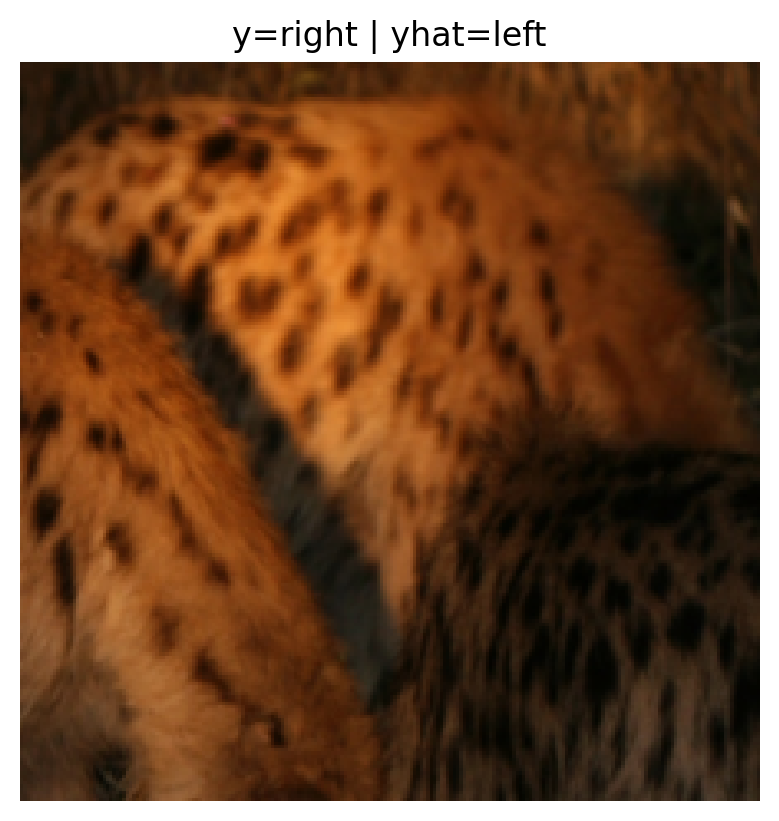

In [138]:
val_iter = iter(val_ds)
next(val_iter);next(val_iter);next(val_iter);next(val_iter)
img, lbl = next(val_iter)
logits = model(img.unsqueeze(0).to(device))
prediction = logits.argmax(dim=1).item()
plt.imshow(unnormalize(img).permute(1, 2, 0).numpy())
plt.axis('off')
plt.title(f'y={int2view[lbl]} | yhat={int2view[prediction]}');